In [59]:
import bagpy
from bagpy import bagreader
import numpy as np
from scipy.signal import savgol_filter
#%matplotlib # for interactive plots
from matplotlib import pyplot as plt
from numpy.polynomial.polynomial import polyfit

In [60]:
# This program computes the thrust map between normalized thrust (m/s^2) and PX4 normalized thrust (range 0-1)
# Record a rosbag during a flight with 
#   rosbag record /mavros/setpoint_raw/target_attitude /mavros/imu/data /mavros/local_position/pose

# /mavros/setpoint_raw/target_attitude contains messages:
#   header
#   thrust (PX4 normalized thrust)
#   orientation (orientation target)
#   body_rate (body rate target)

# /mavros/imu/data contains messages:
#   header
#   orientation
#   angular_velocity
#   linear_acceleration

# /mavros/local_position/pose contains messages:
#   header
#   pose

In [61]:
# Load rosbag

#path = '/home/sequoyah/ROS/rosbags/'
path = '/filespace/w/walters/ROS/VIO_quad/rosbags/'
#bag_file = 'sim_thrust_map.bag'
bag_file = '2023-07-21-03-51-16.bag'
bag = bagreader(path + bag_file)
print("\nMessage types: ", bag.message_types)
print("Message frequencies: ", bag.frequency)

[INFO]  Data folder /filespace/w/walters/ROS/VIO_quad/rosbags/2023-07-21-03-51-16 already exists. Not creating.

Message types:  ['sensor_msgs/Imu', 'geometry_msgs/PoseStamped', 'mavros_msgs/AttitudeTarget']
Message frequencies:  [48.25365270012195, 30.178539821417008, 10.01962212948121]


In [62]:
# Convert to csv files

target_att_csv = bag.message_by_topic('/mavros/setpoint_raw/target_attitude')
imu_csv = bag.message_by_topic('/mavros/imu/data')
pose_csv = bag.message_by_topic('/mavros/local_position/pose')
print(target_att_csv,'\n', imu_csv,'\n', pose_csv)

/filespace/w/walters/ROS/VIO_quad/rosbags/2023-07-21-03-51-16/mavros-setpoint_raw-target_attitude.csv 
 /filespace/w/walters/ROS/VIO_quad/rosbags/2023-07-21-03-51-16/mavros-imu-data.csv 
 /filespace/w/walters/ROS/VIO_quad/rosbags/2023-07-21-03-51-16/mavros-local_position-pose.csv


In [63]:
# Convert to numpy arrays

target_att_data = np.genfromtxt(target_att_csv, delimiter=',', dtype=float, names=True)
imu_data = np.genfromtxt(imu_csv, delimiter=',', dtype=float, names=True)
pose_data = np.genfromtxt(pose_csv, delimiter=',', dtype=float, names=True)

# Show field names
#print(target_att_data.dtype.names)
#print(imu_data.dtype.names)
print(pose_data.dtype.names)

('Time', 'headerseq', 'headerstampsecs', 'headerstampnsecs', 'headerframe_id', 'posepositionx', 'posepositiony', 'posepositionz', 'poseorientationx', 'poseorientationy', 'poseorientationz', 'poseorientationw')


In [64]:
# Extract important data

# PX4 Normalized thrust [0,1]
thrust_times_init = target_att_data['Time']
PX4thrust_init = target_att_data['thrust']
thrust_times = thrust_times_init[PX4thrust_init < 1.0]
PX4thrust = PX4thrust_init[PX4thrust_init < 1.0]

# Acceleration in body frame (m/s^2)
imu_times = imu_data['Time']
acc = np.empty((thrust_times.size, 3))
acc[:] = np.nan;
# smooth the acceleration data
acc_x_smooth = savgol_filter(imu_data['linear_accelerationx'], 41, 6) # window size 41, polynomial order 5
acc_y_smooth = savgol_filter(imu_data['linear_accelerationy'], 41, 6)
acc_z_smooth = savgol_filter(imu_data['linear_accelerationz'], 41, 6) #17, 5
# interpolate to match thrust_times
acc[:,0] = np.interp(thrust_times, imu_times, acc_x_smooth)  # acc x
acc[:,1] = np.interp(thrust_times, imu_times, acc_y_smooth)  # acc y
acc[:,2] = np.interp(thrust_times, imu_times, acc_z_smooth)  # acc z

# Attitude data
att = np.empty((thrust_times.size, 4))
att[:] = np.nan
# interpolate to match thrust_times
att[:,0] = np.interp(thrust_times, imu_times, imu_data['orientationw'])  # att w
att[:,1] = np.interp(thrust_times, imu_times, imu_data['orientationx'])  # att x
att[:,2] = np.interp(thrust_times, imu_times, imu_data['orientationy'])  # att y
att[:,3] = np.interp(thrust_times, imu_times, imu_data['orientationz'])  # att z

# Altitude data
alt_times = pose_data['Time']
# interpolate to match thrust_times
alt = np.interp(thrust_times, alt_times, pose_data['posepositionz']) # pos z
min_alt = 0.2 # minimum altitude (m) considered not touching ground

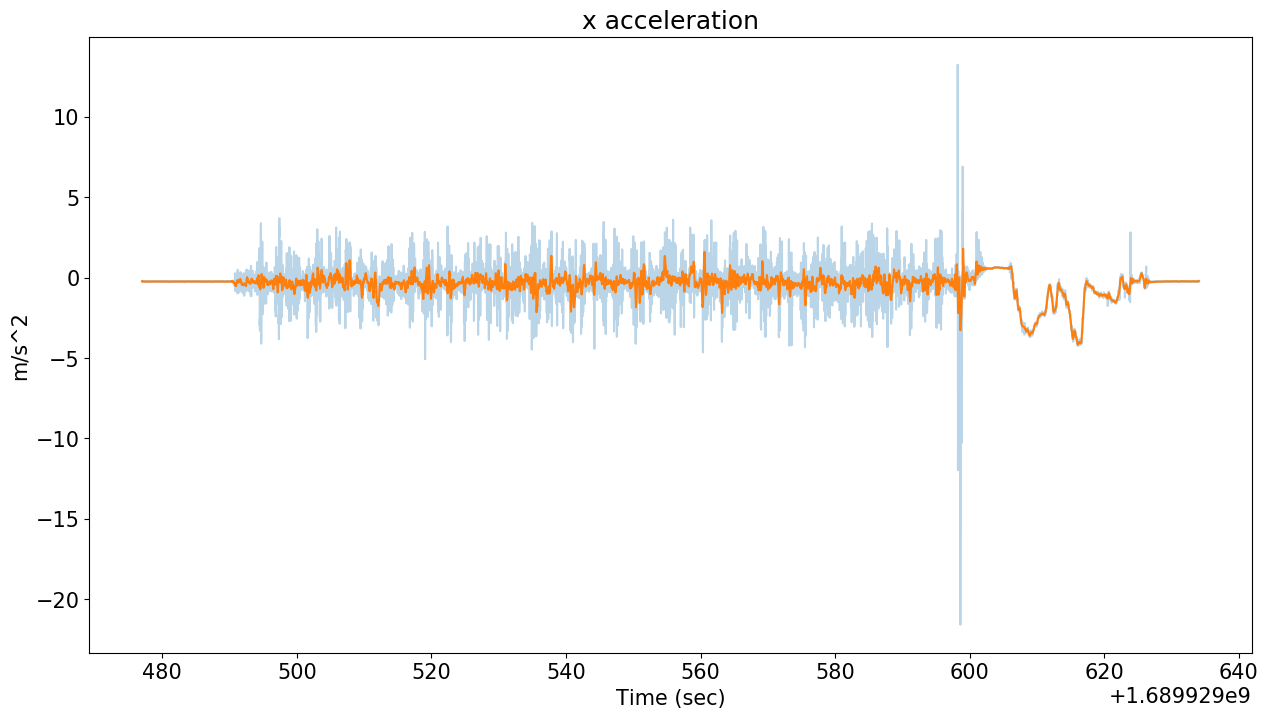

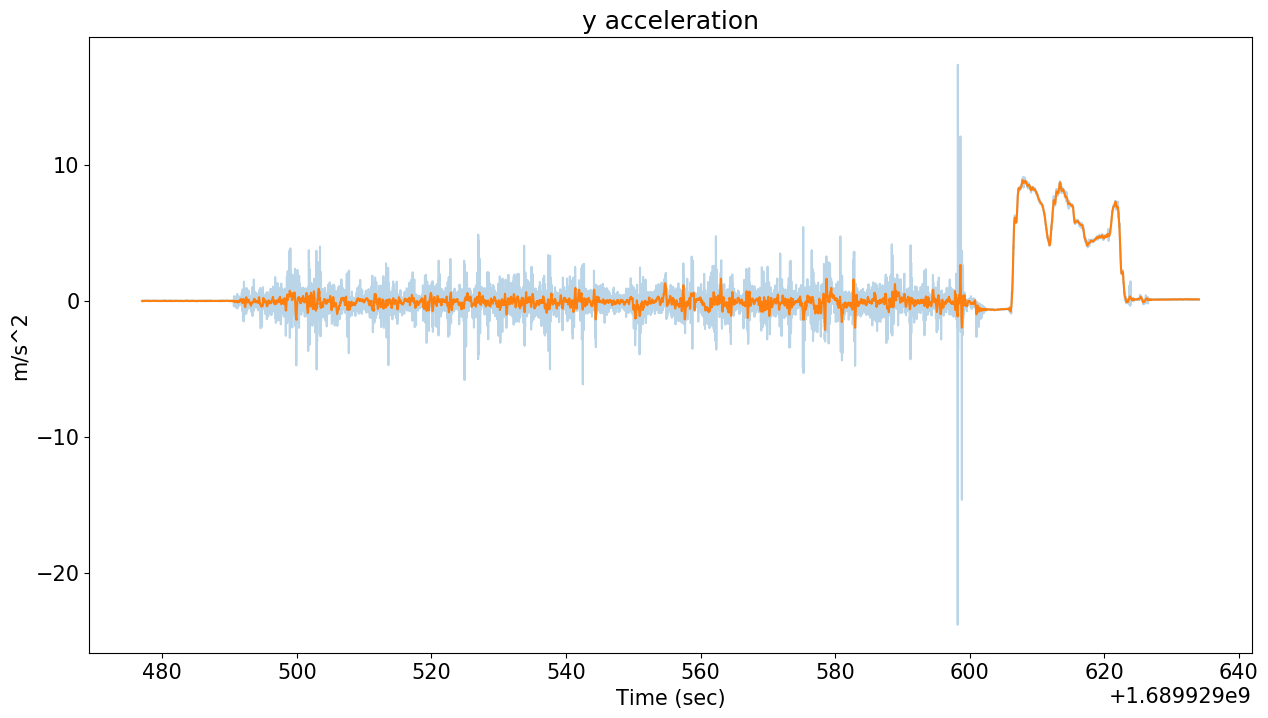

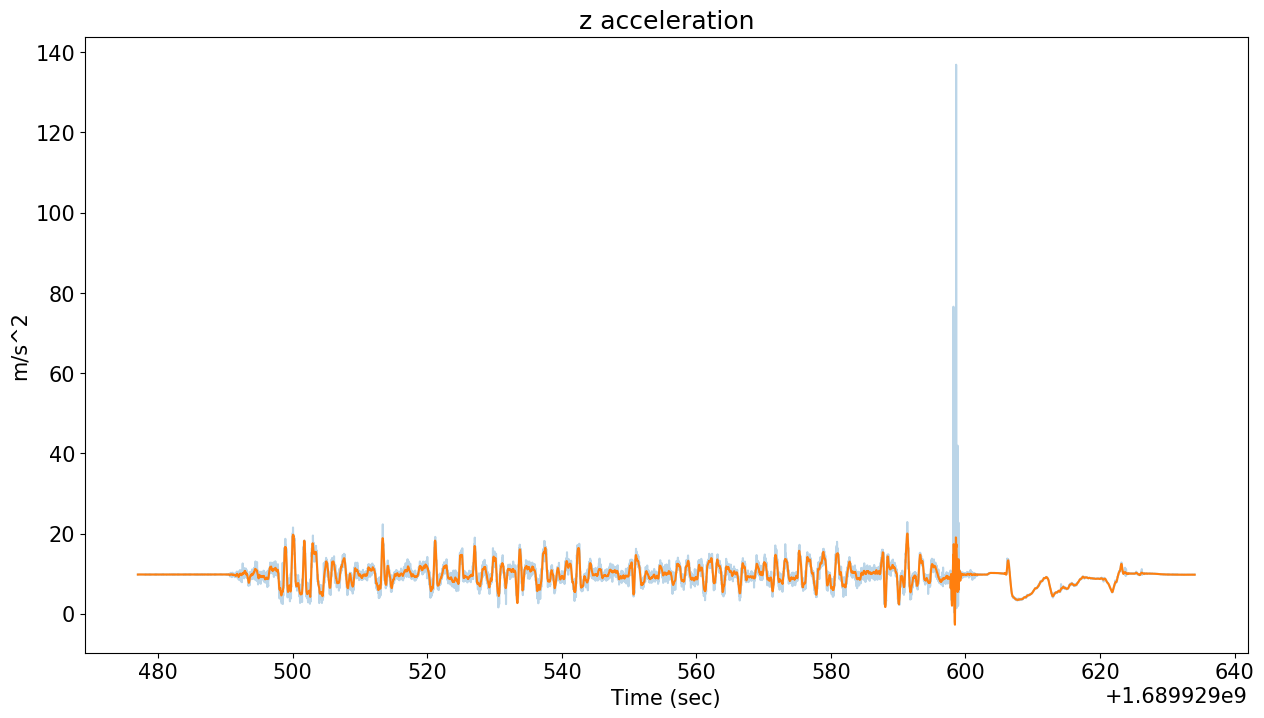

In [65]:
# Set plot params
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['font.size'] = 15
#print(plt.rcParams.keys)

# show smoothing effect
plt.figure(0)
plt.plot(imu_times, imu_data['linear_accelerationx'], alpha=0.3)
plt.plot(imu_times, acc_x_smooth)
plt.xlabel('Time (sec)')
plt.ylabel('m/s^2')
plt.title('x acceleration')
plt.figure(1)
plt.plot(imu_times, imu_data['linear_accelerationy'], alpha=0.3)
plt.plot(imu_times, acc_y_smooth)
plt.xlabel('Time (sec)')
plt.ylabel('m/s^2')
plt.title('y acceleration')
plt.figure(2)
plt.plot(imu_times, imu_data['linear_accelerationz'], alpha=0.3)
plt.plot(imu_times, acc_z_smooth)
plt.xlabel('Time (sec)')
plt.ylabel('m/s^2')
plt.title('z acceleration')
plt.show()

In [66]:
# Functions for rotating a 3-vector by a quaternion

def q_mult(q1, q0):
    # quaternion product q1xq0
    w0, x0, y0, z0 = q0
    w1, x1, y1, z1 = q1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)
def q_inv(q):
    # quaternion inverse
    return np.array([-q[0], q[1], q[2], q[3]])
def pnt2q(pnt):
    # represent a 3-vector as a quaternion
    return np.array([0, pnt[0], pnt[1], pnt[2]])
def q2pnt(q):
    # remove extra zero from rotated pnt
    assert abs(q[0]) < 1e-14, f"q[0] too big, got: {q[0]}" # make sure the removed value is about zero
    return np.array([q[1], q[2], q[3]])
def q_rotate(pnt, q):
    # rotate pnt by q
    result_q = q_mult(q_inv(q), q_mult( pnt2q(pnt),q))
    return q2pnt(result_q)

In [67]:
# Estimate mass-normalized thrust

acc_w = np.empty(3)
g_vect = np.array([0,0,9.81])
mass_norm_thrust = np.empty(thrust_times.size)
mass_norm_thrust[:] = np.nan

for i in range(thrust_times.size):
    acc_w = q_rotate(acc[i,:], att[i,:]) # Express imu acceleration in world frame (values include gravity)
    mass_norm_thrust[i] = np.linalg.norm(acc_w) # Estimate mass-normalized thrust

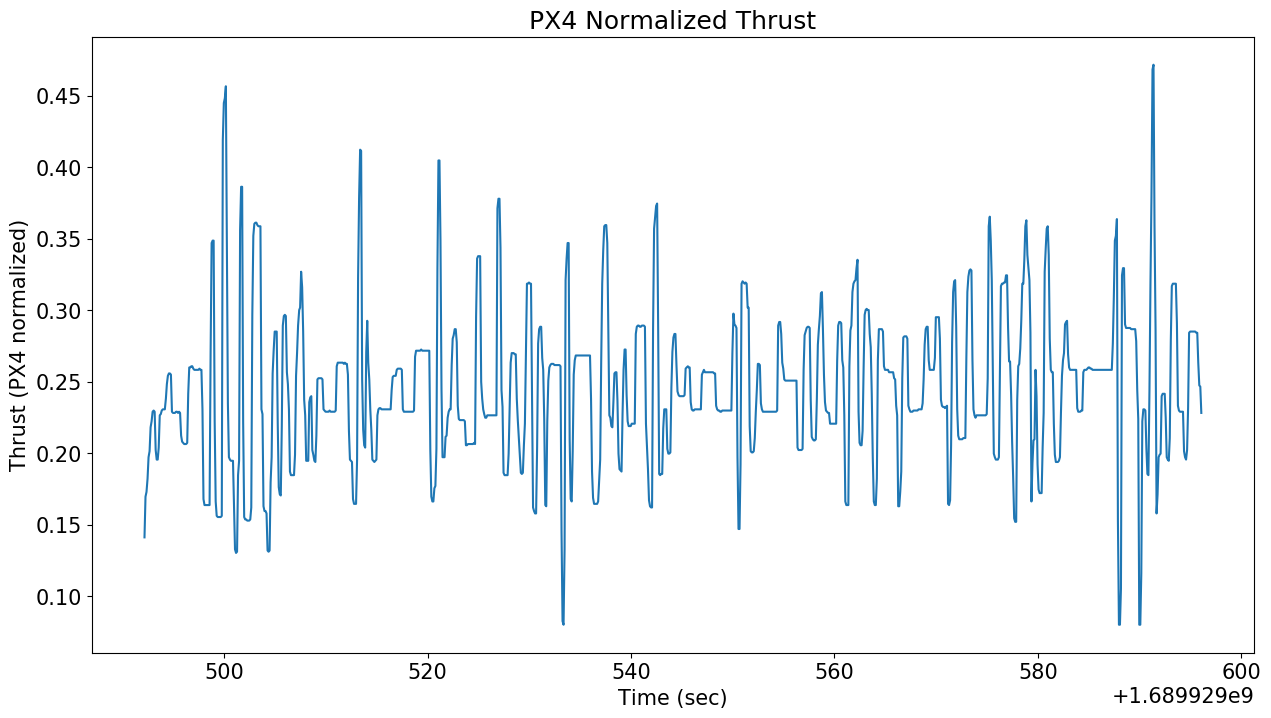

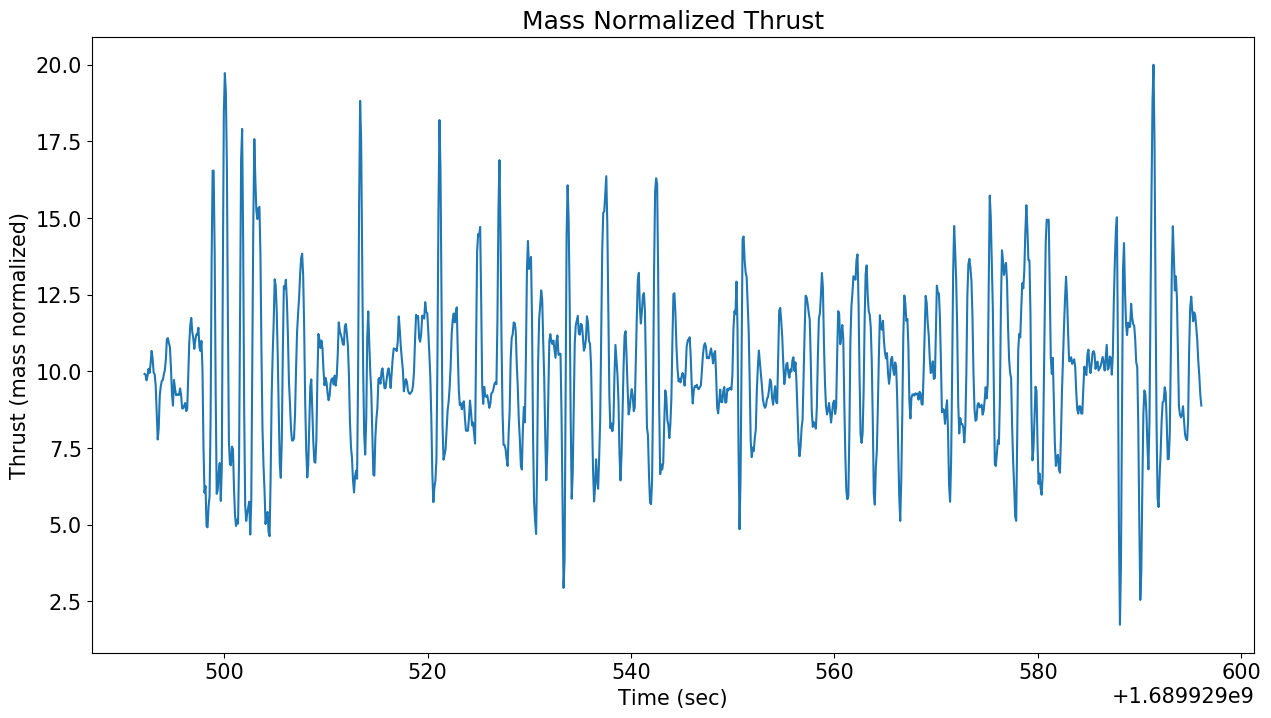

In [94]:
# Create plots

start_sec = thrust_times[0] + 15  # add 1 to start 1 second later
end_sec = thrust_times[-1] - 38   # subtract 2 to end 2 secs earlier
# select indices to satisfy desired time region, and desired altitutde
plt_idx = (thrust_times > start_sec)* \
          (thrust_times < end_sec)
#* \
#          (alt > min_alt)

plt.figure(3)
plt.plot(thrust_times[plt_idx], PX4thrust[plt_idx])
plt.xlabel('Time (sec)')
plt.ylabel('Thrust (PX4 normalized)')
plt.title('PX4 Normalized Thrust')

plt.figure(4)
plt.plot(thrust_times[plt_idx], mass_norm_thrust[plt_idx])
plt.xlabel('Time (sec)')
plt.ylabel('Thrust (mass normalized)')
plt.title('Mass Normalized Thrust')

# Display the plots
plt.show()

In [1]:
# Fit polynomial to data

mnt_fit = mass_norm_thrust[plt_idx]
px4t_fit = PX4thrust[plt_idx]

# Append zeros
mnt_fit = np.append(mnt_fit, np.zeros(30))
px4t_fit = np.append(px4t_fit, np.zeros(30))

d, c, b, a = polyfit(mnt_fit,  px4t_fit, 3)
print([a,b,c,d])
#a,b,c,d = [0.00013850414341400538, -0.005408755617324549, 0.11336157680888627, -0.0022807568577082674]
x = np.linspace(0,20,100)

plt.figure(5)
plt.plot(mnt_fit, px4t_fit, '.')
plt.xlabel('Mass normalized thrust ($m/s^2$)')
plt.ylabel('PX4 normalized thrust')
plt.title('Thrust mapping')
plt.xlim(-0.35)
plt.ylim(-0.05,1.05)

# plot ploynomial
plt.plot(x, a*x*x*x + b*x*x + c*x + d)

# Display the plots
plt.show() # comment this out if using interactive plots

NameError: name 'mass_norm_thrust' is not defined